# All fingers Primary Model Pipeline

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('/nfs/2018/j/jcruz-y-/neurotron_datasets/joined/joined_data_106979_24-Oct-19_17:31_jose_all_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [5]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571891e+09,0.006226,1.571891e+09,50.0,250.0,396.0,89.0,53.0,43.0,31.0,61.0,9.262085,-9.118690,47.617905,-18.114399,-8.678528,51.673462,-46.709621,-12.567474,17.094170,-69.877258,-11.163055,-3.096992,-85.138763,-10.990265,-17.690151,-20.603283,15.033867,-19.298096,-18.594982,29.675285,-55.134228,-23.628544,21.952751,-74.898529,-29.280987,9.089638,-81.241966,-1.600807,9.199806,-21.184177,9.602978,22.597313,-61.013245,5.366776,12.613152,-84.265617,-2.429310,-1.073235,-90.542023,16.659401,0.454193,-17.607121,31.992260,15.967636,-51.509766,30.006121,9.053932,-75.447060,22.099865,-3.387665,-83.625824,31.320591,-11.242180,-12.971455,48.320904,0.762253,-37.152554,49.054413,-1.940414,-54.576313,42.004250,-10.960121,-65.103134
1,1.571891e+09,-0.029152,1.571891e+09,50.0,286.0,368.0,74.0,51.0,29.0,23.0,42.0,6.786233,-11.333852,47.534789,-20.769446,-11.812599,49.990927,-48.818829,-12.573416,14.808353,-71.526649,-9.472275,-5.685904,-86.040143,-8.497499,-20.978106,-19.892583,15.473871,-19.684725,-16.363919,31.977931,-54.562784,-20.061439,25.205292,-74.945980,-24.964155,12.585976,-82.297033,-0.656441,10.240284,-20.741277,12.169991,25.430847,-59.404511,9.774177,16.861857,-83.445555,3.000662,3.609998,-91.510464,17.612489,1.798022,-16.543760,34.630843,19.197273,-48.656146,34.708936,13.781877,-73.032392,28.021311,1.851053,-82.843496,32.317179,-9.737174,-11.650706,50.569850,3.507205,-34.192403,52.642263,1.569894,-51.594506,46.731619,-7.074512,-63.067226
2,1.571891e+09,0.001225,1.571891e+09,48.0,270.0,347.0,69.0,50.0,29.0,22.0,37.0,5.317806,-12.499672,47.453987,-22.304150,-13.473961,48.934364,-50.567093,-11.620216,13.915695,-73.125786,-7.157860,-6.519272,-87.022034,-5.696548,-22.351597,-19.449600,15.688126,-19.963085,-15.181034,33.082428,-54.341133,-18.064960,27.075287,-75.106461,-22.477337,14.810486,-83.337776,-0.101135,10.783897,-20.485744,13.475960,26.486450,-58.701767,12.304794,18.931656,-83.193710,6.364304,6.209526,-92.698830,18.149715,2.515739,-15.874870,36.093548,20.546936,-47.148628,37.534588,16.020477,-71.687836,31.792110,4.564583,-82.641403,32.863037,-8.918983,-10.774841,52.029774,4.644127,-32.373928,55.188416,3.101257,-49.667633,50.315052,-5.215370,-61.872467
3,1.571891e+09,0.009088,1.571891e+09,49.0,245.0,326.0,66.0,39.0,28.0,23.0,36.0,5.141285,-12.493469,47.475067,-22.483795,-13.559532,48.828407,-50.828781,-11.390457,13.894257,-73.361900,-6.804001,-6.541451,-87.106232,-5.372879,-22.508564,-19.409599,15.628494,-20.048607,-15.110043,33.002945,-54.432831,-17.841034,27.203735,-75.277794,-22.137730,15.102798,-83.807457,-0.042805,10.788460,-20.483543,13.552137,26.346481,-58.752304,12.602261,18.943726,-83.300186,6.865059,6.356377,-93.104897,18.213963,2.579636,-15.790806,36.240501,20.540024,-47.057739,37.922184,16.111511,-71.599510,32.396820,4.750542,-82.761627,32.941494,-8.807564,-10.625877,52.218910,4.702339,-32.159714,55.573746,3.183128,-49.418533,50.933563,-5.084938,-61.746620
4,1

In [6]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [7]:
df = df[:5000]
df.shape

(5000, 71)

In [8]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,109.102400,199.677800,286.003200,135.899200,55.258200,51.769400,74.662600,67.408000,-5.198813,-4.246083,49.331277,-30.954265,-12.171475,43.779154,-33.136000,-27.828879,2.232312,-34.050009,-38.630949,-25.679954,-33.266757,-46.313609,-43.933759,-16.147558,6.953186,-27.217459,-9.839613,4.582677,-62.449130,-7.468645,-3.910228,-78.402134,-6.615928,-12.163438,-86.350045,3.037245,7.395347,-21.761870,16.219966,3.364677,-59.527298,20.624587,-7.191090,-77.584082,21.739136,-16.544398,-86.085147,20.573374,5.078548,-11.017020,32.790314,-2.546990,-45.122998,36.491999,-14.423493,-62.642792,36.960269,-24.823603,-71.564043,35.428416,-1.032715,-0.111580,47.617296,-8.150331,-26.029792,50.290362,-17.045287,-38.509005,49.950458,-26.994540,-47.183958
std,173.018963,138.596875,192.954632,105.992267,43.090116,82.997964,102.766254,119.905831,7.825778,12.190646,3.788470,9.800771,15.679564,6.693409,11.071813,11.329830,8.770653,17.970047,12.536696,11.399894,23.877210,14.451606,13.516239,4.981293,7.309155,2.614449,9.796797,21.186227,6.538009,12.201428,30.338838,13.164475,14.133833,35.794664,20.373427,4.593345,5.510408,2.370834,11.057274,21.757272,7.659924,17.158616,32.237881,14.072279,21.998403,37.982428,20.781485,3.825444,7.407345,3.480968,11.088655,19.102271,9.238345,18.338105,27.336048,15.629497,23.663257,31.927795,21.444579,3.772627,11.050847,4.768862,10.740999,16.127557,8.768980,17.135544,19.597015,12.049278,22.886125,22.102120,16.090146
min,19.000000,20.000000,23.000000,26.000000,20.000000,17.000000,16.000000,17.000000,-28.459534,-36.025116,12.642181,-51.847256,-50.313751,7.371819,-67.971062,-62.493591,-32.309222,-90.193291,-85.025411,-58.903809,-102.430875,-103.504150,-80.039200,-31.425241,-31.792175,-31.811234,-42.302876,-67.396919,-73.383875,-50.308414,-85.256256,-96.546054,-55.500813,-100.575760,-112.462585,-16.552727,-20.359009,-25.657837,-25.828159,-63.445162,-72.724304,-41.345818,-88.000181,-98.275253,-53.070572,-104.996796,-115.310730,-6.564236,-15.865082,-23.457855,-7.488388,-50.211551,-63.275589,-24.174629,-75.105942,-87.228676,-38.265263,-91.151232,-104.522316,6.307455,-35.751801,

In [9]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

### Raw labels and features

In [10]:
#feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values
label_tips = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
print(label_ar.shape)
print(label_tips.shape)

(5000, 63)
(5000, 18)


### Making Spectograms


In [11]:
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']
shape = (7, 13, 8)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 12
noverlap = 11
reshape = (-1, shape[0], shape[1], shape[2])
j = 1
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

img = np.zeros(shape)
k = 0
num_samples = len(df)
x_shape = (num_samples, 7, 13, 8)
x1_train = np.zeros(x_shape)

for i in range(len(df) - 24):
    for j in range(8):
        frequencies, times, spec = signal.spectrogram(x=df[channels[j]][k:k+24], fs=50,
                                                  nperseg=nperseg, noverlap=noverlap,
                                                  window='hann')
        log_spec = np.log(spec)
        img[:,:,j] = spec
        j = j + 1
    x1_train[i,:,:,:] = img
    i = i + 1
    k = k + 1
    if i == 4457:
        print(df.iloc[i,:])
    print(i)
print(x1_train.shape)
flat = np.reshape(x1_train, (num_samples, flat_dim))
df_train1 = pd.DataFrame(data=flat)
df_train_g = df_train_g.append(df_train1, ignore_index=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/nfs/2018/j/jcruz-y-/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469


2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149


4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657


## Preprocess features and get labels
Reshaping
Handling overflow (inf) and underflow (-inf) <br>


In [23]:
def preprocess_features(x_train):
    shape = (7, 13, 8)
    reshape = (-1, shape[0], shape[1], shape[2])
    x_train = x_train.replace(-np.inf, 0)
    x_train = x_train.replace(np.inf, 0)
    #x_train = np.log(x_train.values)
    x_train = x_train.values
    x_train_norm = x_train.reshape(reshape)
    return x_train_norm

features = preprocess_features(df_train_g)
labels = df.loc[:, 'Wrist x':].values
labels_tips = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]

### Reshaping samples
The target shape corresponds to (sequence_number, frequency_axis, time_axis, input_dim)

In [24]:
seq_length = 24

def reshape_overlap_samples(seq_length, feats, labels):
    samples = feats.shape[0] - (seq_length - 1)    # all samples except the last sequence
    shape = (24, 7, 13, 8)
    new_f = np.zeros(shape=(samples, 24, 7, 13, 8))
    print(new_f.shape)
    new_l = labels[seq_length - 1:]
    queue = collections.deque(feats[:seq_length])
    new_f[0] = np.array(queue)
    j = 1
    for i in range(seq_length, feats.shape[0]):
        queue.popleft()
        queue.append(feats[i])
        new_f[j] = np.array(queue)
        j += 1
    return (new_f, new_l)

features_ol, labels_ol = reshape_overlap_samples(seq_length, features, labels_tips)
print(features_ol.shape)
print(labels_ol.shape)

(4977, 24, 7, 13, 8)
(4977, 24, 7, 13, 8)
(4977, 18)


### CNN_LSTM
Not going too down because of 'relu' activation function

In [32]:
def create_model(input_shape):

    inputlayer = Input(shape=input_shape)
    norm_input = BatchNormalization()(inputlayer)
    model = TimeDistributed(Conv2D(32, kernel_size=2, padding='same', activation='relu'))(norm_input)
    model = Dropout(rate=0.2)(model)
    model = BatchNormalization()(model)
    model = TimeDistributed(Conv2D(32, kernel_size=2, padding='same', activation='relu'))(model)
    model = Dropout(rate=0.2)(model)
    model = BatchNormalization()(model)
    #model = BatchNormalization()(TimeDistributed(Dense(128, activation='relu')(model)))
    model = TimeDistributed(Flatten())(model)
    model = LSTM(64, activation='relu', return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)
    model = LSTM(64, activation='relu', return_sequences=False)(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)#(Dense(63, activation='relu')(model))
    dense = Dense(18, activation=None)(model)
    model = Model(inputs=inputlayer, outputs=dense)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model

print(shape)
model = create_model((24, 7, 13, 8))

model.summary()

(24, 7, 13, 8)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 7, 13, 8)]    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 7, 13, 8)      32        
_________________________________________________________________
time_distributed_9 (TimeDist (None, 24, 7, 13, 32)     1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 7, 13, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 7, 13, 32)     128       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 7, 13, 32)     4128      
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 7, 1

In [26]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [27]:
model.evaluate(features_ol, labels_ol, verbose=1)

4977/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

446990.0803224128

In [30]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=10
                    , verbose=1, validation_split=0.2, shuffle=False)

Train on 3981 samples, validate on 996 samples
Epoch 1/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 422.4906 - val_loss: 311.9832
Epoch 2/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 437.3758 - val_loss: 326.0894
Epoch 3/10
3981/3981 [==============================] - 30s 7ms/sample - loss: 443.1009 - val_loss: 280.0540
Epoch 4/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 435.5993 - val_loss: 283.8537
Epoch 5/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 432.2566 - val_loss: 297.7552
Epoch 6/10
3981/3981 [==============================] - 37s 9ms/sample - loss: 431.0414 - val_loss: 301.8677
Epoch 7/10
3981/3981 [==============================] - 39s 10ms/sample - loss: 427.2439 - val_loss: 291.4190
Epoch 8/10
3981/3981 [==============================] - 35s 9ms/sample - loss: 424.4643 - val_loss: 296.4846
Epoch 9/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 4

### ConvLSTM2D

In [34]:
def create_model(input_shape):
    inputlayer = Input(shape=input_shape)
    
    norm_input = BatchNormalization()(inputlayer)
    model = ConvLSTM2D(16, kernel_size=2, padding='same', activation='relu', return_sequences=True)(norm_input)
    model = Dropout(rate=0.3)(model)
    #model = ConvLSTM2D(16, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    model = Dropout(rate=0.3)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    #model = Dropout(rate=0.5)(model)
    model = Flatten()(model)
    #mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    model = Dense(18, activation=None)(model)
    
    model = Model(inputs=inputlayer, outputs=model)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model

shape = (24, 7, 13, 8)
model = create_model(shape)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 7, 13, 8)]    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 24, 7, 13, 8)      32        
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 24, 7, 13, 16)     6208      
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 7, 13, 16)     0         
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 7, 13, 32)         24704     
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 13, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2912)              0   

In [35]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [36]:
model.evaluate(features_ol, labels_ol, verbose=1)

4977/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

505800.1363787092

In [37]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=6
                    , verbose=1, validation_split=0.2, shuffle=False)

Train on 3981 samples, validate on 996 samples
Epoch 1/6
3981/3981 [==============================] - 97s 24ms/sample - loss: 13606.0753 - val_loss: 2370.4555
Epoch 2/6
3981/3981 [==============================] - 93s 23ms/sample - loss: 151770.9785 - val_loss: 2371.2936
Epoch 3/6
3981/3981 [==============================] - 101s 25ms/sample - loss: 3219.9044 - val_loss: 2303.9436
Epoch 4/6
3981/3981 [==============================] - 96s 24ms/sample - loss: 2381.8404 - val_loss: 2280.1367
Epoch 5/6
3981/3981 [==============================] - 96s 24ms/sample - loss: 3872.9792 - val_loss: 3506.5822
Epoch 6/6
3981/3981 [==============================] - 92s 23ms/sample - loss: 22452.1551 - val_loss: 2357.7340


## Autoencoder
The final pipeline will pass the data into an LSTM and then into an autoencoder to expand features into the 63 point space. This autoencoder will be trained first below:

In [10]:
feature_ar.shape

(106979, 8)

In [11]:
label_ar.shape

(106979, 63)

Build the autoencoder structure:

In [12]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(63,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(16, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(32, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(63, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
decoder_0 (Dense)            (None, 16)                160       
_________________________________________________________________
decoder_1 (Dense)            (None, 32)                544       
_________________________________________________________________
decoder_output (Dense)       (None, 63)                2079  

In [23]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(18,))
#dense_0 = Dense(9, activation=a_fn)(input_vec)
#dense_1 = Dense(5, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(input_vec)
#dense_2 = Dense(5, activation=a_fn, name='decoder_0')(encoded)
#dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(18, activation=a_fn, name='decoder_output')(encoded)

autoencoder_tips = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
#decode_0 = autoencoder.layers[-3](decoder_input)
#decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decoder_input)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder_tips.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder_tips.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 171       
_________________________________________________________________
decoder_output (Dense)       (None, 18)                180       
Total params: 351
Trainable params: 351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.evaluate(label_ar, label_ar)

In [24]:
autoencoder_tips.evaluate(label_tips, label_tips)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6631.058497845517

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [ ]:
ret = autoencoder.fit(label_ar, label_ar, batch_size=312, epochs=10, verbose=1, validation_split=0.2)

In [30]:
ret = autoencoder_tips.fit(label_tips, label_tips, batch_size=312, epochs=10, verbose=1, validation_split=0.2)

Train on 85583 samples, validate on 21396 samples
Epoch 1/10
85583/85583 [==============================] - 1s 7us/sample - loss: 24.5897 - val_loss: 31.2787
Epoch 2/10
85583/85583 [==============================] - 1s 7us/sample - loss: 24.3930 - val_loss: 31.0273
Epoch 3/10
85583/85583 [==============================] - 1s 6us/sample - loss: 24.2394 - val_loss: 30.8665
Epoch 4/10
85583/85583 [==============================] - 1s 6us/sample - loss: 24.1134 - val_loss: 30.4065
Epoch 5/10
85583/85583 [==============================] - 1s 7us/sample - loss: 24.0083 - val_loss: 30.4927
Epoch 6/10
85583/85583 [==============================] - 1s 7us/sample - loss: 23.9261 - val_loss: 30.2513
Epoch 7/10
85583/85583 [==============================] - 1s 8us/sample - loss: 23.8553 - val_loss: 30.1568
Epoch 8/10
85583/85583 [==============================] - 1s 7us/sample - loss: 23.8007 - val_loss: 30.0027
Epoch 9/10
85583/85583 [==============================] - 1s 6us/sample - loss: 23.757

Now the encoder - decoder pair will be tested seperately for loss: 20 aprox

In [33]:
encoded_vec = encoder.predict(label_tips)
decoded_vec = decoder.predict(encoded_vec)

#compilation is only to enable evaluation
decoder.compile(optimizer='adam', loss='mse')
decoder.evaluate(encoded_vec, label_tips)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5556.819701115771

In [34]:
print(encoded_vec.shape)
print(decoded_vec.shape)

(106979, 9)
(106979, 18)


## LSTM
Here the lstm will be trained. The 8 channels of sEMG data will be processed by the LSTM, which will return a vector of 9 complex features. These will then be processed by the autoencoder, trained in the previous section, to create the 63 hand coordinates.

To train the sequential recurrent LSTM the data will be grouped into 'sequences' of 24 steps in time. The LSTM will be trained with many sequence groups.

In [43]:
seq_length = 24

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
features, labels_tips = overlap_samples(seq_length, feature_ar, label_tips)
print(features.shape)
print(labels.shape)
print(labels_tips.shape)

(106956, 24, 8)
(106956, 63)
(106956, 18)


In [44]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
model = LSTM(32, return_sequences=True, name='lstm_0')(inputs)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = LSTM(32, return_sequences=True, name='lstm_1')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = LSTM(32, return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = LSTM(32, return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = LSTM(32, return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = LSTM(32, return_sequences=True)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = LSTM(32, return_sequences=False)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = Dense(9, activation=None)(model)

#decoder layers
#decoder_0 = decoder.get_layer("decoder_0")(model)
#decoder_0.trainable = False
#decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
#decoder_1.trainable = False
#decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output = decoder.get_layer("decoder_output")(model)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 8)]         0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 32)          5248      
_________________________________________________________________
dropout_28 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
batch_normalization_28 (Batc (None, None, 32)          128       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
batch_normalization_29 (Batc (None, None, 32)          128

In [46]:
model.evaluate(features, labels_tips, verbose=1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2383.4007993247515

In [ ]:
#class_weights = 

In [56]:
history = model.fit(features, labels_tips, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2,
                    callbacks=[tensorboard])

Train on 85564 samples, validate on 21392 samples
Epoch 1/4
85564/85564 [==============================] - 320s 4ms/sample - loss: 596.2451 - val_loss: 830.7177
Epoch 2/4
85564/85564 [==============================] - 295s 3ms/sample - loss: 576.3131 - val_loss: 813.1110
Epoch 3/4
85564/85564 [==============================] - 305s 4ms/sample - loss: 558.5094 - val_loss: 790.9144
Epoch 4/4
85564/85564 [==============================] - 330s 4ms/sample - loss: 541.7303 - val_loss: 806.8447


### Visualize Model Error

Plot the validation loss over the training epochs:

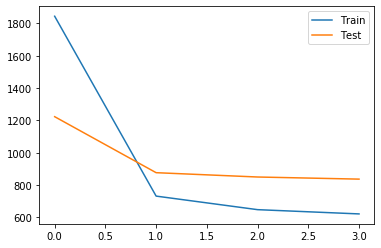

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.show()

Plotting the errors for each field below shows that the 'y' coordinates for each figure generally have the largest error and the errors growing rapidly approaching the tips of the fingers.

In [51]:
preds = model.predict(features)

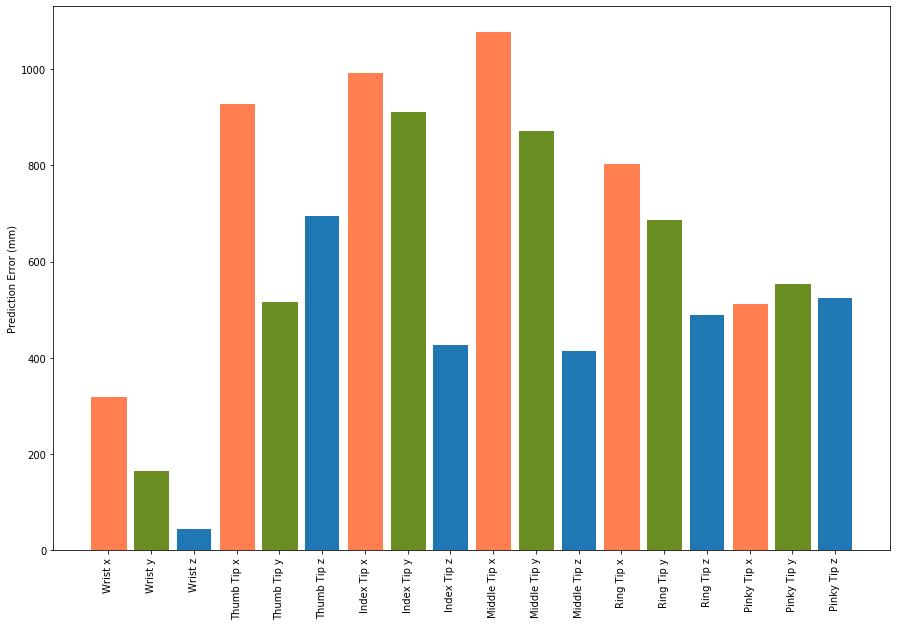

In [55]:
error = labels_tips - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
#bar = plt.bar(df.columns[8:], avg_error)
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Winner?

In [ ]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(256, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(256, return_sequences=True))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(128))
model_fc.add(BatchNormalization())
model_fc.add(Dense(512, input_dim=128))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(512, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(256, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(63, input_dim=64))
model_fc.compile(optimizer='Adam', loss='mse')
model_fc.summary()

In [ ]:
history = model_fc.fit(features, labels, batch_size=seq_le iiingth, epochs=4, verbose=1, validation_split=0.2)

In [ ]:
model_fc.save('FC_model_jose_all_val_loss_400_1.h5')

## LSTM with Fully Connected Layers
Below is a test using a model with several dense layers after the LSTM layers, instead of using the pretrained autoencoder.

In [ ]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

In [ ]:
model_fc.save('FC_model_jose_all_val_loss_100_1.h5')

### Visual Model Error

In [50]:
preds = model_fc.predict(features)

NameError: name 'model_fc' is not defined

In [ ]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement. This is done on both of the architectures tested above.

### Autoencoder Architecture

In [ ]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(18,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(18, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
label_ar_t = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_t.shape

In [ ]:
ret = autoencoder.fit(label_ar_t, label_ar_t, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

Create a smaller labels vector with only the tip and wrist x,y,z:

In [ ]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

In [ ]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

In [ ]:
history = model.fit(features, labels_tip, batch_size=seq_length, epochs=1, verbose=1, validation_split=0.2)

### Visual Model Error
Model error for the reduced Autoencoder architecture:

In [ ]:
preds = model.predict(features)

In [ ]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Tips only with FC Architecture

In [ ]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(18, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=seq_length, epochs=9, verbose=1, validation_split=0.2)

### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

In [ ]:
preds = model_fc.predict(features)

In [ ]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()